### Dataset loading

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# changing directory to location of dataset
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
# listing all files in directory
os.listdir()

['linx maintanence',
 'abhishek resume modified1.docx',
 'Marks Format - Default.gsheet',
 'REPLY.gdoc',
 'PRESENTATION EFFECTIVELY.gdoc',
 'PRESENTATION.gdoc',
 'Abhishek resume.docx',
 'Colab Notebooks',
 'Untitled spreadsheet.gsheet',
 '1581660proposal.docx',
 '1581660.docx',
 'Tr0.zip',
 'Tr0',
 'yaleExtB_data.npy',
 'yaleExtB_target.npy',
 'loandatafiltered.csv',
 'UK women survey 20-40 age group.gform',
 'Dataset - Large dataset shared from Google Drive and Skeleton Code',
 'NIT6004 Data.zip']

In [ ]:
# unzipping all folders in the zip file
import zipfile
with zipfile.ZipFile('NIT6004 Data.zip', 'r') as zip_ref:
    # Extract all files in the zip archive
    zip_ref.extractall('/content/')

In [ ]:
os.listdir('/content/data')

['non-vehicles', 'vehicles']

In [ ]:
# loading all necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetV2S

In [ ]:
# function to load all images from a folder directory
def load_images_from_folder(folder):
    imgnames = os.listdir(folder)
    images = cv2.imread(os.path.join(folder,imgnames[0]))[:,:,::-1]
    w = images.shape[0]; h = images.shape[1]
    print('First 10 '+ folder.split(sep='/')[-1]+ ' images in RGB format:')
    plt.figure(figsize=(10,15))
    plt.subplot(1,10,1)
    plt.imshow(images)
    plt.xticks([])
    plt.yticks([])
    i = 2
    images = images.reshape(1,w,h,3)
    for filename in imgnames[1::]:
        img = cv2.imread(os.path.join(folder,filename))[:,:,::-1]
        if img is not None:
            if i <=10:
                plt.subplot(1,10,i)
                plt.imshow(img)
                plt.xticks([])
                plt.yticks([])
                i=i+1
            images = np.vstack((images,img.reshape(1,w,h,3)))
    plt.show()
    labels = [folder.split(sep='/')[-1]]*images.shape[0]
    return images,labels

First 10 non-vehicles images in RGB format:


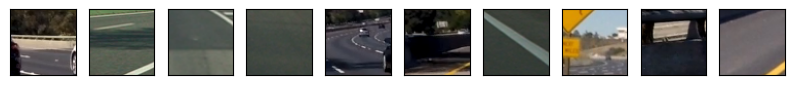

In [ ]:
nocarimgs,nocarlabels = load_images_from_folder('/content/data/non-vehicles')
print('Shape of feature matrix for no-vehicle images:',nocarimgs.shape)

First 10 vehicles images in RGB format:


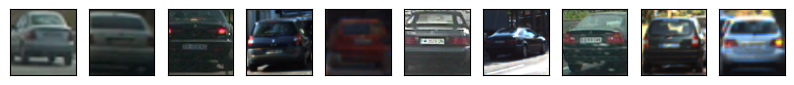

Shape of feature matrix for vehicle images: (8792, 64, 64, 3)


In [ ]:
carimgs,carlabels = load_images_from_folder('/content/data/vehicles')
print('Shape of feature matrix for vehicle images:',carimgs.shape)

### Data pre-processing

In [ ]:
# combining images for both classes and combining class labels to create target variable
X = np.vstack((nocarimgs,carimgs))
y = nocarlabels + carlabels
# get unique labels
labels = np.unique(y)
class_codes = list(range(len(labels)))
# binarize the class variable
ytr = np.array(pd.Series(y).replace(labels,class_codes))

### Train-test split in 80:20 ratio

In [ ]:
# train-test split in 80:20 ratio by stratified sampling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, ytr, test_size=0.2, random_state=2212008,stratify=ytr)
print('Train set feature shape:', X_train.shape)
print('Test set feature shape:', X_test.shape)

Train set feature shape: (14208, 64, 64, 3)
Test set feature shape: (3552, 64, 64, 3)


### CNN model design and training

In [ ]:
# Defining the CNN architecture using tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
# clearing TF session before each run
tf.keras.backend.clear_session()
tf.random.set_seed(2212008) # random seed for reproducibility of fitting and results
# Model architecture starting from sequential layer
cnnmodel = Sequential()
cnnmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64,3)))
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dense(64, activation='relu'))
cnnmodel.add(Dense(len(labels), activation= "sigmoid"))
print(cnnmodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [ ]:
cnnmodel.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = "adam",\
                 metrics = ["sparse_categorical_accuracy"])
hist1 = cnnmodel.fit(X_train, y_train,validation_split=0.1, epochs = 10,batch_size = 256)

Epoch 1/10
50/50 [==============================] - 103s 2s/step - loss: 0.3502 - sparse_categorical_accuracy: 0.8416 - val_loss: 0.1601 - val_sparse_categorical_accuracy: 0.9423
Epoch 2/10
50/50 [==============================] - 100s 2s/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.1121 - val_sparse_categorical_accuracy: 0.9648
Epoch 3/10
50/50 [==============================] - 100s 2s/step - loss: 0.0791 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9711
Epoch 4/10
50/50 [==============================] - 102s 2s/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.0534 - val_sparse_categorical_accuracy: 0.9810
Epoch 5/10
50/50 [==============================] - 98s 2s/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.0509 - val_sparse_categorical_accuracy: 0.9824
Epoch 6/10
50/50 [==============================] - 99s 2s/step - loss: 0.0321 - sparse_categorical_accura

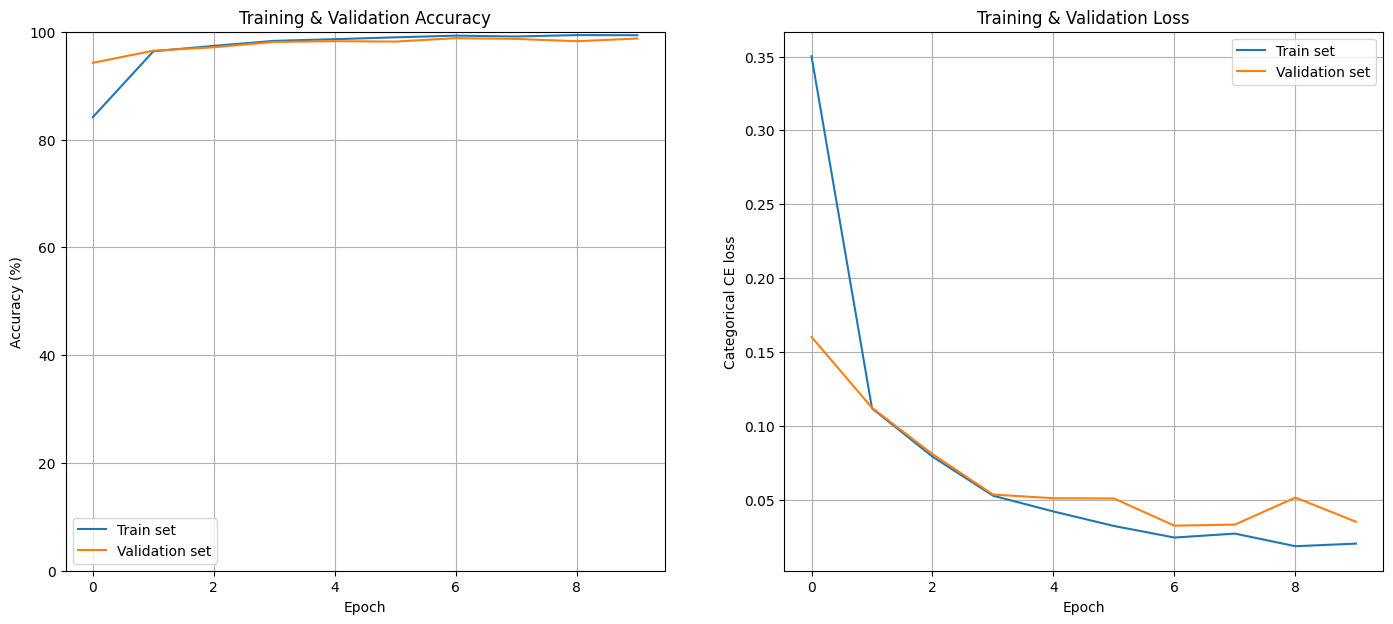

In [ ]:
# plotting the accuracy, loss for train and validation set over epoch
def plot_history(history):
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(17,7)
    ax[0].plot(np.array(history.history['sparse_categorical_accuracy'])*100, label='accuracy')
    ax[0].plot(np.array(history.history['val_sparse_categorical_accuracy'])*100, label = 'val_accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].grid()
    ax[0].set_ylim([0,100])
    ax[0].legend(['Train set','Validation set'],loc='best')
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'validation loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Categorical CE loss')
    ax[1].grid()
    ax[1].legend(['Train set','Validation set'],loc='best')
    plt.show()
plot_history(hist1)

### CNN model evaluation in test set

111/111 [==============================] - 7s 64ms/step
Test set classification report by CNN model:
              precision    recall  f1-score   support

non-vehicles       1.00      0.98      0.99      1794
    vehicles       0.98      1.00      0.99      1758

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



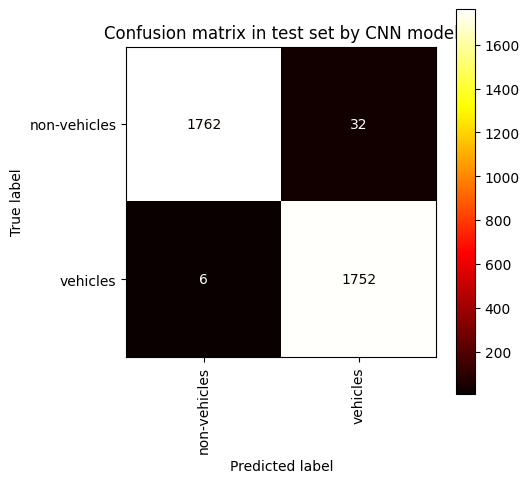

In [ ]:
# Model evaluation in test set in terms of accuracy, precision, recall, f1 score resulting from binary confusion matrix
y_pred = cnnmodel.predict(X_test).argmax(axis=1)
print('Test set classification report by CNN model:')
print(classification_report(y_test,y_pred,labels= class_codes,target_names=labels,zero_division=0))
con_mat = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat,display_labels=labels)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax,cmap='hot')
plt.xticks(rotation = 90)
plt.title('Confusion matrix in test set by CNN model')
plt.show()

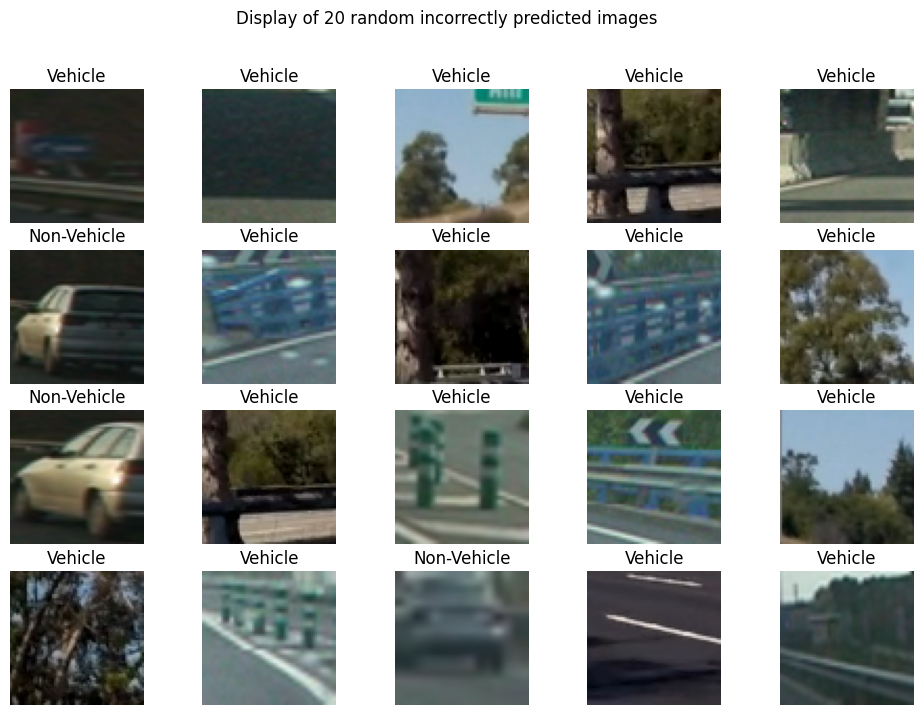

In [ ]:
# Sample 20 incorrectly classified images display from test set
preds = y_pred[y_test != y_pred]
plt.figure(figsize=(12,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_test[y_test != y_pred][i])
  plt.axis('off')
  if preds[i] == 0:
    plt.title('Non-Vehicle')
  else:
    plt.title('Vehicle')
plt.suptitle('Display of 20 random incorrectly predicted images')
plt.show()

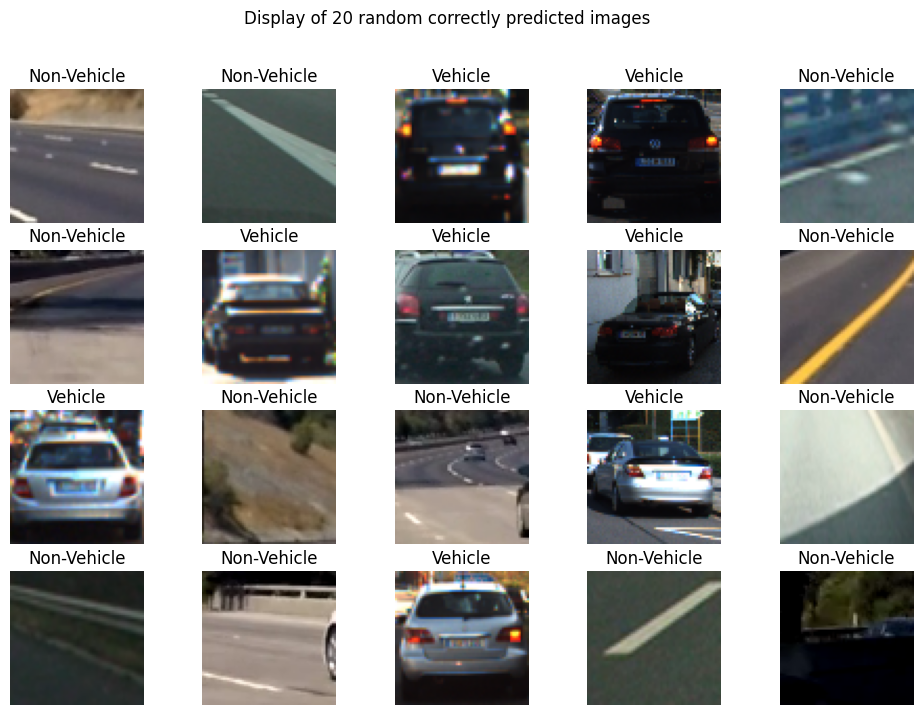

In [ ]:
# Sample 20 correctly classified images display from test set
preds = y_pred[y_test == y_pred]
plt.figure(figsize=(12,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_test[y_test == y_pred][i])
  plt.axis('off')
  if preds[i] == 0:
    plt.title('Non-Vehicle')
  else:
    plt.title('Vehicle')
plt.suptitle('Display of 20 random correctly predicted images')
plt.show()

### EfficientNetV2S

In [ ]:
# Clearing TF session before each run
tf.keras.backend.clear_session()
tf.random.set_seed(2212008)  # Random seed for reproducibility of fitting and results

# Load EfficientNetV2S model (pretrained on ImageNet)
effnetv2_model = EfficientNetV2S(include_top=False, input_shape=(64, 64, 3), weights='imagenet',pooling='max')

# Freeze the weights of the EfficientNetV2S model
effnetv2_model.trainable = False

# Build the model architecture
model = Sequential()
model.add(effnetv2_model)
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))

# Print model summary
print(model.summary())

82420632/82420632 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 20,333,922
Trainable params: 2,562
Non-trainable params: 20,331,360
_________________________________________________________________
None


In [ ]:
# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"]
)

# Train the model
hist2 = model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5
200/200 [==============================] - 234s 1s/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.0183 - val_sparse_categorical_accuracy: 0.9972
Epoch 2/5
200/200 [==============================] - 235s 1s/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 0.9986
Epoch 3/5
200/200 [==============================] - 216s 1s/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0074 - val_sparse_categorical_accuracy: 0.9986
Epoch 4/5
200/200 [==============================] - 213s 1s/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0063 - val_sparse_categorical_accuracy: 0.9979
Epoch 5/5
200/200 [==============================] - 236s 1s/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0046 - val_sparse_categorical_accuracy: 0.9993


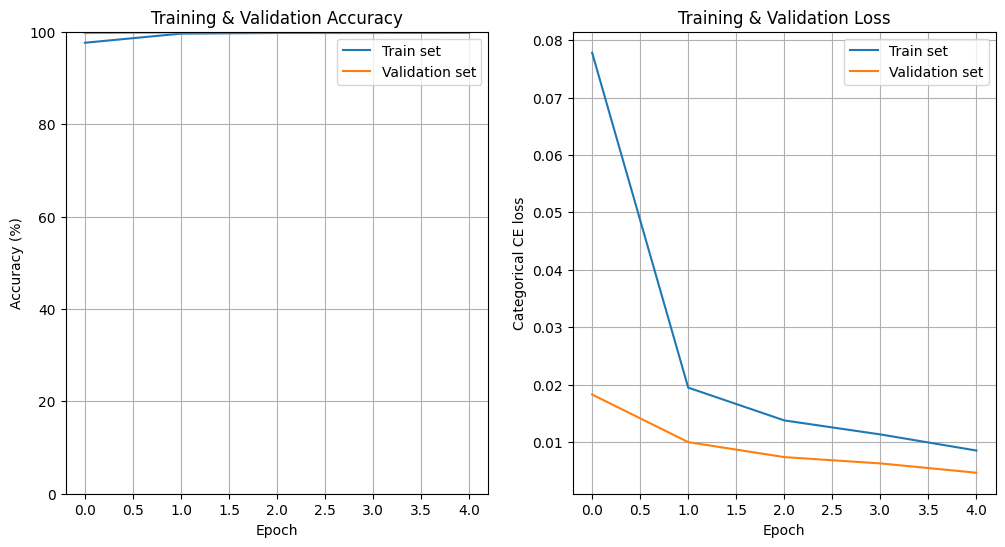

In [ ]:
# plotting the accuracy, loss for train and validation set over epoch
def plot_history(history):
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(12,6)
    ax[0].plot(np.array(history.history['sparse_categorical_accuracy'])*100, label='accuracy')
    ax[0].plot(np.array(history.history['val_sparse_categorical_accuracy'])*100, label = 'val_accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].grid()
    ax[0].set_ylim([0,100])
    ax[0].legend(['Train set','Validation set'],loc='best')
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'validation loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Categorical CE loss')
    ax[1].grid()
    ax[1].legend(['Train set','Validation set'],loc='best')
plot_history(hist2)

In [ ]:
def test_perf(X_test,y_test,model,alias):
  y_pred = model.predict(X_test).argmax(axis=1)
  print('Test set classification report by: ',alias)
  print(classification_report(y_test,y_pred,target_names=['non-vehicle','vehicle'],zero_division=0))
  con_mat = confusion_matrix(y_test,y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=con_mat,display_labels=['non-vehicle','vehicle'])
  fig, ax = plt.subplots(figsize=(5,5))
  disp.plot(ax=ax,cmap='hot')
  plt.xticks(rotation = 90)
  plt.title('Confusion matrix in test set by '+alias)
  plt.show()


111/111 [==============================] - 58s 483ms/step
Test set classification report by:  EfficientNetV2S
              precision    recall  f1-score   support

 non-vehicle       1.00      1.00      1.00      1794
     vehicle       1.00      1.00      1.00      1758

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552



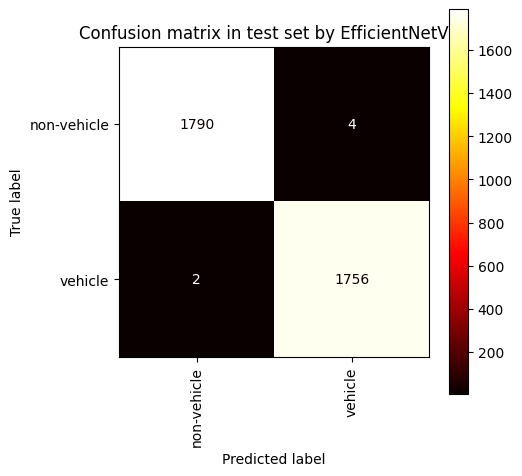

In [ ]:
test_perf(X_test,y_test,model,'EfficientNetV2S')

### MLP neural network

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(2212008)
mlp = Sequential()
mlp.add(Flatten(input_shape=(64, 64, 3)))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(len(labels), activation= "sigmoid"))
print(mlp.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,189,282
Trainable params: 3,189,282
Non-

In [ ]:
# Compile the model

mlp.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"]
)

X_train_norm = X_train/255; X_test_norm = X_test/255
# Train the model
hist3 = mlp.fit(X_train_norm, y_train, validation_split=0.1, epochs=10, batch_size=256)

Epoch 1/10
50/50 [==============================] - 8s 141ms/step - loss: 0.6107 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.8621
Epoch 2/10
50/50 [==============================] - 6s 110ms/step - loss: 0.2995 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.2825 - val_sparse_categorical_accuracy: 0.8839
Epoch 3/10
50/50 [==============================] - 6s 112ms/step - loss: 0.2584 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.2415 - val_sparse_categorical_accuracy: 0.9085
Epoch 4/10
50/50 [==============================] - 7s 140ms/step - loss: 0.2042 - sparse_categorical_accuracy: 0.9165 - val_loss: 0.2204 - val_sparse_categorical_accuracy: 0.9163
Epoch 5/10
50/50 [==============================] - 5s 104ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.9302 - val_loss: 0.1905 - val_sparse_categorical_accuracy: 0.9324
Epoch 6/10
50/50 [==============================] - 7s 145ms/step - loss: 0.1851 - sparse_categorica

111/111 [==============================] - 1s 8ms/step
Test set classification report by:  MLP ANN
              precision    recall  f1-score   support

 non-vehicle       0.94      0.97      0.96      1794
     vehicle       0.97      0.94      0.95      1758

    accuracy                           0.95      3552
   macro avg       0.96      0.95      0.95      3552
weighted avg       0.96      0.95      0.95      3552



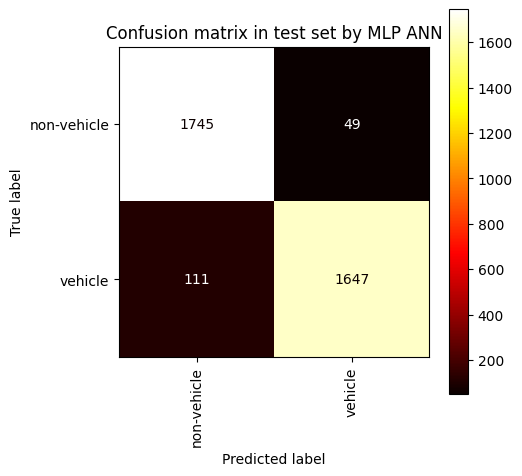

In [ ]:
test_perf(X_test_norm,y_test,mlp,'MLP ANN')

### MobileNetV3

In [ ]:
# Clearing TF session before each run
from tensorflow.keras.applications import MobileNetV3Small
tf.keras.backend.clear_session()
tf.random.set_seed(2212008)  # Random seed for reproducibility of fitting and results

# Load  model (pretrained on ImageNet)
mobnetv3s = MobileNetV3Small(include_top=False, input_shape=(64, 64, 3), weights='imagenet',pooling='max',alpha=0.75)

# Freeze the weights of the mobilenet model
mobnetv3s.trainable = False

# Build the model architecture
mobnet = Sequential()
mobnet.add(mobnetv3s)
mobnet.add(Flatten())
mobnet.add(Dense(len(labels), activation='sigmoid'))

# Print model summary
print(mobnet.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 432)              583160    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 432)               0         
                                                                 
 dense (Dense)               (None, 2)                 866       
                                                                 
Total params: 584,026
Trainable params: 866
Non-trainable params: 583,160
_________________________________________________________________
None


In [ ]:
# Compile the model
mobnet.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"]
)

# Train the model
hist4 = mobnet.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5
200/200 [==============================] - 20s 80ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9137 - val_loss: 0.0957 - val_sparse_categorical_accuracy: 0.9676
Epoch 2/5
200/200 [==============================] - 15s 75ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0701 - val_sparse_categorical_accuracy: 0.9754
Epoch 3/5
200/200 [==============================] - 15s 75ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.0589 - val_sparse_categorical_accuracy: 0.9824
Epoch 4/5
200/200 [==============================] - 15s 75ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0548 - val_sparse_categorical_accuracy: 0.9817
Epoch 5/5
200/200 [==============================] - 15s 74ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.0520 - val_sparse_categorical_accuracy: 0.9824


111/111 [==============================] - 5s 33ms/step
Test set classification report by:  MobileNetV3Small
              precision    recall  f1-score   support

 non-vehicle       0.98      0.99      0.99      1794
     vehicle       0.99      0.98      0.98      1758

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



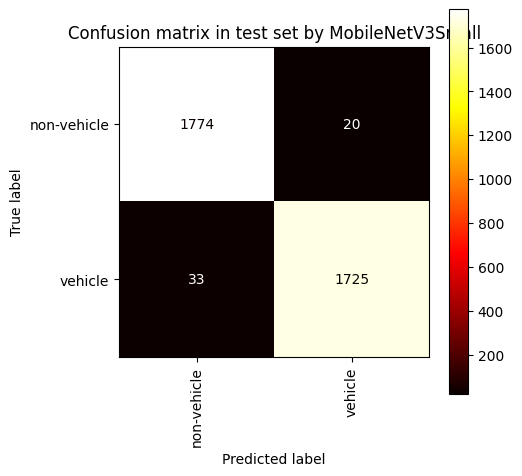

In [ ]:
test_perf(X_test,y_test,mobnet,'MobileNetV3Small')